In [4]:
import pandas as pd
import numpy as np
from mxnet import gpu
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import timedelta

from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer

from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

# predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# 预测新增的确诊、死亡、康复
confirmed = pd.read_csv('raw_data/COVID/time_series_covid19_confirmed_global.csv')
# 拿2019年的indicators
indicators = pd.read_excel('raw_data/SUSTAIN database_08Jan2021_Asia and Latin America.xlsx')[['Country', 'Indicator', 2019]]
policy = pd.read_excel('raw_data/SUSTAIN database_25Feb2021_policies_Asia and Latin America.xlsx')

In [7]:
# confirmed.head(10)
# len(list(set(policy.entity)))
# len(list(set(indicators.Country)))
# len(list(set(confirmed['Country/Region'])))
countries = sorted(list(set(policy.entity).intersection(set(confirmed['Country/Region'])).intersection(set(indicators['Country']))))
indicator_names = list(set(indicators.Indicator))
policy_names = [x for x in list(policy.columns) if x not in ['entity', 'iso', 'date']]

In [8]:
# target (should def a function)，最后添加虚假数据用来预测
# num_series, series length
confirmed_series = confirmed.groupby('Country/Region').sum().drop(['Lat', 'Long'],axis=1).loc[countries, :].T[countries].fillna(0)
confirmed_series.index = pd.to_datetime(confirmed_series.index)
confirmed_series = confirmed_series.diff()[1:]  # 预测增量

# # scaler
target_scaler = StandardScaler().fit(confirmed_series.iloc[:-10])
# # 在这里构造代预测的数据
target = target_scaler.transform(confirmed_series).T

In [9]:
# define the parameters of the dataset
custom_ds_metadata = {'num_series': len(countries),
                      'num_steps': len(confirmed_series),
                      'prediction_length': 10,
                      'context_length': 10,
                      'freq': '1D',
                      'start': [pd.Timestamp(confirmed_series.index[0], freq='1D')
                                for _ in range(len(confirmed_series))]
                     }

In [10]:
# static covariate (indicators)
# num_series, indicator num
indicators_values = indicators.pivot_table(index='Indicator', columns='Country', values=2019)[countries].fillna(0).T
covariate_s = MinMaxScaler().fit_transform(indicators_values)

In [11]:
# dynamic covariate（time feature and policies）
# num_series, num policies, series length + (prediction length)
covariate_d = []
for policy_name in policy_names:
    tmp = policy[['entity', 'date', policy_name]].pivot_table(index='date', columns='entity', values=policy_name)
    for x in countries:
        if x not in tmp.columns:
            tmp[x] = 0
    tmp = tmp[countries]
    tmp.index = pd.to_datetime(tmp.index)
    
    for index in confirmed_series.index:
        if index not in tmp.index:
            tmp.loc[index] = 0
        
    tmp = tmp.sort_index()
    tmp = tmp.loc[confirmed_series.index[0]:confirmed_series.index[-1]].fillna(0)
#     tmp_value = MinMaxScaler().fit_transform(tmp).T
    tmp_value = tmp.T.values
    covariate_d.append(tmp_value)
covariate_d = np.array(covariate_d).transpose(1, 0, 2)

In [12]:
train_ds = ListDataset([{FieldName.TARGET: target,
                         FieldName.START: start,
                         FieldName.FEAT_STATIC_REAL: fsr,
                         FieldName.FEAT_DYNAMIC_REAL: fdr,
                        }
                        for (target, start, fsr, fdr) in zip(target[:, :-custom_ds_metadata['prediction_length']],
                                                             custom_ds_metadata['start'],
                                                             covariate_s,
                                                             covariate_d[:, :, :-custom_ds_metadata['prediction_length']],
                                                            )],
                      freq=custom_ds_metadata['freq'])

test_ds = ListDataset([{FieldName.TARGET: target,
                        FieldName.START: start,
                        FieldName.FEAT_STATIC_REAL: fsr,
                        FieldName.FEAT_DYNAMIC_REAL: fdr,
                       }
                       for (target, start, fsr, fdr) in zip(target,
                                                  custom_ds_metadata['start'],
                                                  covariate_s,
                                                  covariate_d,
                                                      )],
                     freq=custom_ds_metadata['freq'])

In [26]:
from gluonts.mx.distribution import StudentTOutput

from model.my_network import MyProbEstimator
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=custom_ds_metadata['context_length'],
    freq=custom_ds_metadata['freq'],
    distr_output = StudentTOutput(),
    num_cells=[8, 16, 64],  # [static dim, dynamic dim, target dim]
    scaling=True,
    trainer=Trainer(ctx="cpu",#gpu(0),
                    epochs=10,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=32,
                    hybridize=False, 
                   )
)

from gluonts.model.deepar import DeepAREstimator
estimator = DeepAREstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=custom_ds_metadata['context_length'],
    freq=custom_ds_metadata['freq'],
    distr_output = StudentTOutput(),
    trainer=Trainer(ctx="cpu",#gpu(0),
                    epochs=10,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=32,
                   )
)

In [27]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:03<00:00, 30.61it/s, epoch=10/10, avg_epoch_loss=-.483]


In [28]:
# predictor.serialize(Path("/tmp/"))
# help(make_evaluation_predictions)


In [29]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [30]:
tss = list(ts_it)
# sampling
forecasts = list(forecast_it)

# distribution
# forecasts = [np.array(x.distribution.mean.asnumpy()) for x in list(forecast_it)]

In [31]:
country_index = 40
ts_entry = tss[country_index]
forecast_entry = forecasts[country_index]

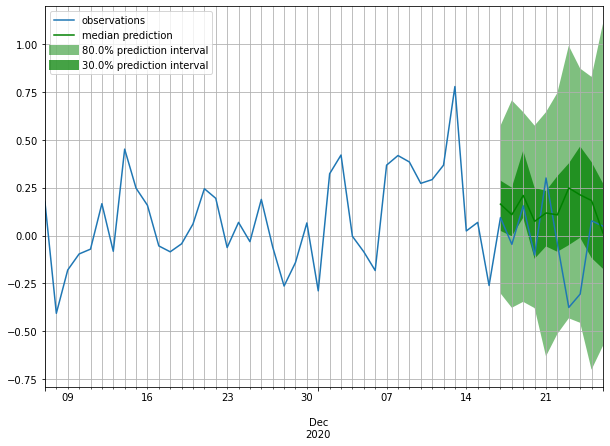

In [32]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 50
    prediction_intervals = (30.0, 80.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series -10
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)

In [33]:
confirmed_series = confirmed.groupby('Country/Region').sum().drop(['Lat', 'Long'],axis=1).loc[countries, :].T[countries].fillna(0)
confirmed_series.index = pd.to_datetime(confirmed_series.index)
history = confirmed_series.iloc[:-10]
history.to_csv('output/step_one/recovered/history.csv')  # 存历史数据
confirmed_series[-12:]

Country/Region,Afghanistan,Argentina,Bangladesh,Belize,Bhutan,Bolivia,Brazil,Brunei,Cambodia,Chile,...,Panama,Paraguay,Peru,Philippines,Singapore,Sri Lanka,Suriname,Thailand,Uruguay,Venezuela
2020-12-15,48952,1510203,494209,9511,439,147716,6970034,152,362,575329,...,196987,95353,986130,451839,58341,34121,5381,4261,10418,108480
2020-12-16,49161,1517046,495841,9672,440,148214,7040608,152,362,576731,...,199947,96209,986130,452988,58353,34737,5401,4281,10893,108717
2020-12-17,49378,1524372,496975,9791,440,148665,7110434,152,362,578732,...,203295,97028,989457,454447,58377,35387,5428,4297,11436,109081
2020-12-18,49621,1531374,498293,9791,443,149149,7162978,152,362,581135,...,206310,98296,989457,456562,58386,36049,5459,4331,11950,109395
2020-12-19,49681,1537169,499560,9791,443,149770,7213155,152,362,583355,...,209584,99157,989457,458044,58403,36667,5511,4907,12557,109781
2020-12-20,49817,1541285,500713,9791,446,150023,7238600,152,363,585546,...,212339,99789,995899,459789,58422,37261,5552,4907,13048,110075
2020-12-21,50013,1547138,502183,10145,479,150385,7263619,152,363,587993,...,214038,100612,997517,461505,58432,37631,5583,5716,13477,110513
2020-12-22,50190,1555279,503501,10257,479,151059,7318821,152,363,589189,...,217202,101544,998475,462815,58461,38059,5669,5716,14001,110828
2020-12-23,50433,1563865,504868,10370,519,152064,7365517,152,363,590914,...,220261,102371,1000153,464004,58482,38639,5734,5762,14710,111024
2020-12-24,50655,1563865,506102,10490,519,153121,7423945,152,363,594152,...,223674,103329,1000153,465724,58495,39231,5810,5910,15457,111245


In [34]:
from gluonts.evaluation import Evaluator
import json

In [35]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 41/41 [00:00<00:00, 123.45it/s]


In [36]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 6.17825361548514,
    "abs_error": 368.8220773935318,
    "abs_target_sum": 612.9144825339317,
    "abs_target_mean": 1.49491337203398,
    "seasonal_error": 0.2987055778503418,
    "MASE": 3.3195782859745098,
    "MAPE": 1.7376035330337303,
    "sMAPE": 0.954585576518477,
    "OWA": NaN,
    "MSIS": 54.815963758591586,
    "QuantileLoss[0.1]": 115.60170513242485,
    "Coverage[0.1]": 0.12439024390243904,
    "QuantileLoss[0.5]": 368.822070075199,
    "Coverage[0.5]": 0.4439024390243903,
    "QuantileLoss[0.9]": 386.668261077255,
    "Coverage[0.9]": 0.7390243902439023,
    "RMSE": 2.4856093046746386,
    "NRMSE": 1.6627112655315386,
    "ND": 0.6017512848917114,
    "wQuantileLoss[0.1]": 0.18860984432036976,
    "wQuantileLoss[0.5]": 0.6017512729514929,
    "wQuantileLoss[0.9]": 0.6308682077125638,
    "mean_absolute_QuantileLoss": 290.3640120949596,
    "mean_wQuantileLoss": 0.4737431083281421,
    "MAE_Coverage": 0.08048780487804881
}
